# Employee Attrition Modeling

**Data:** This analysis uses an HR dataset created by IBM data scientists. The data can be found on Kaggle [here](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset).

## Import Libraries

In [41]:
#Basics
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("white")
sns.set_palette(["#002f4a", "#b85741"])
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)  

#Modeling
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm


## Data Preview
We're working with 1470 observations and 35 columns. A review of the data within Kaggle suggests our data is quite clean; but we'll preview the data below.

Initial observations:
* There does not appear to be any missing data or duplicate employee IDs
* All columns appear to have appropriate initial data types
* All numeric columns appear to have reasonable values (no inherently improbably mins/maxs)
* 16% of employees in the dataset turned over (moderate imbalance, unsurprising)
* Other notable attributes:
    * Most employees never travel (71%)
    * Most employees work in R&D (65%) following by Sales (30%)
    * Most employees come from the Life Sciences or Medical fields (73%)
    * 60% of employees are male
    * Mean age = 36.9 years, sd = 9.1
    * Mean tenure = 7.0 years, sd = 6.1

In [42]:
hr_dat = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
hr_dat.shape

(1470, 35)

In [43]:
hr_dat.info()
hr_dat.head()
hr_dat['EmployeeNumber'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


1470

In [44]:
hr_dat.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


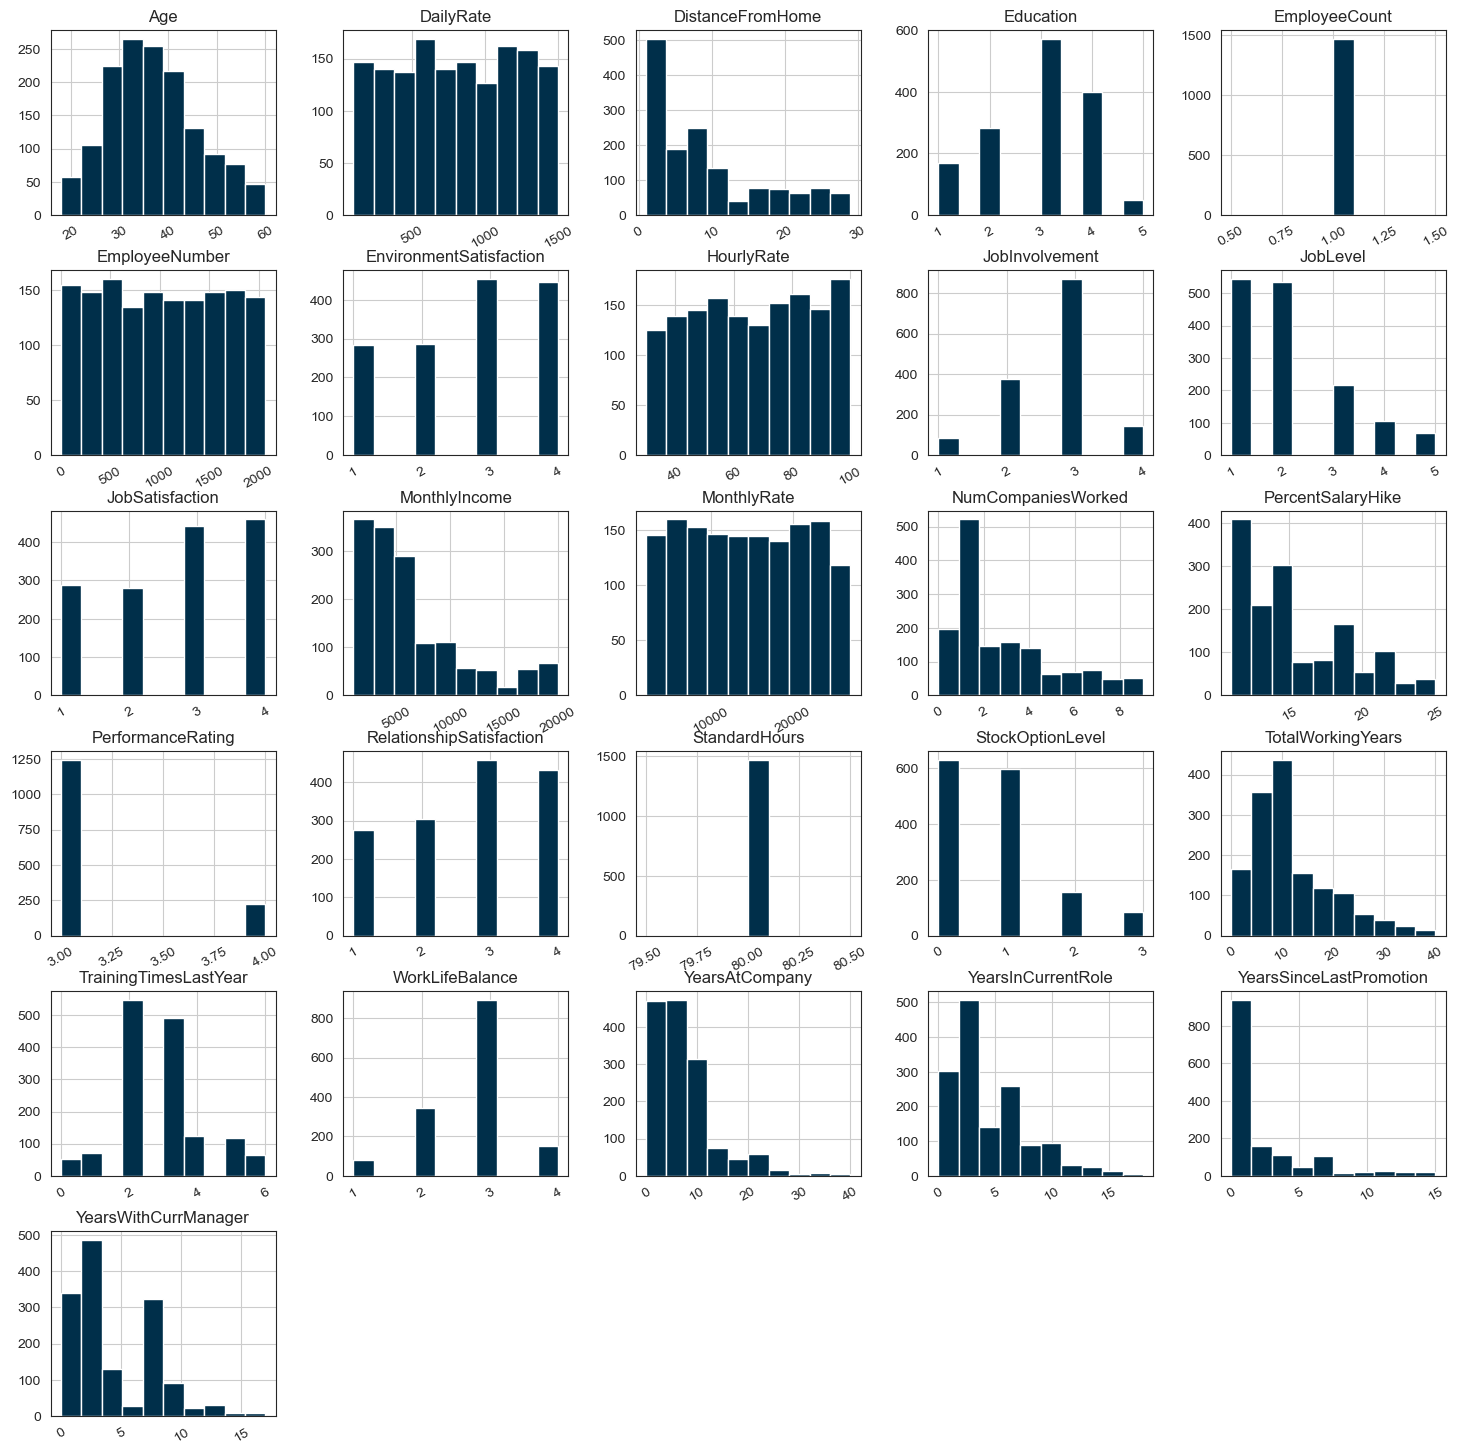

In [45]:
hr_dat.hist(figsize=(18,18), xrot=30)
plt.show();

In [46]:
#review some categorical columns
cat_cols = hr_dat.select_dtypes(include=['object']).columns

for c in cat_cols:
    hr_dat[c].value_counts(normalize = True)
    hr_dat[c].value_counts()

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

No     1233
Yes     237
Name: Attrition, dtype: int64

Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: BusinessTravel, dtype: float64

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: Department, dtype: float64

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

Life Sciences       0.412245
Medical             0.315646
Marketing           0.108163
Technical Degree    0.089796
Other               0.055782
Human Resources     0.018367
Name: EducationField, dtype: float64

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

Male      0.6
Female    0.4
Name: Gender, dtype: float64

Male      882
Female    588
Name: Gender, dtype: int64

Sales Executive              0.221769
Research Scientist           0.198639
Laboratory Technician        0.176190
Manufacturing Director       0.098639
Healthcare Representative    0.089116
Manager                      0.069388
Sales Representative         0.056463
Research Director            0.054422
Human Resources              0.035374
Name: JobRole, dtype: float64

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

Married     0.457823
Single      0.319728
Divorced    0.222449
Name: MaritalStatus, dtype: float64

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

Y    1.0
Name: Over18, dtype: float64

Y    1470
Name: Over18, dtype: int64

No     0.717007
Yes    0.282993
Name: OverTime, dtype: float64

No     1054
Yes     416
Name: OverTime, dtype: int64

From here, we can drop some unnecessary columns:
* EmployeeCount - All 1s
* EmployeeNumber - Unique identifier
* StandardHours - All 80
* Over18 - All Y

In [47]:
hr_clean = hr_dat.drop(columns=['EmployeeCount','EmployeeNumber','StandardHours', 'Over18'], axis=1)

## Exploratory Data Analysis

In [48]:
#Recode attrition column to 1/0
hr_clean['Attrition'] = hr_clean['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
hr_clean['Attrition'].value_counts(normalize=True)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

### Distrubtion of Attrition by Categorical Columns


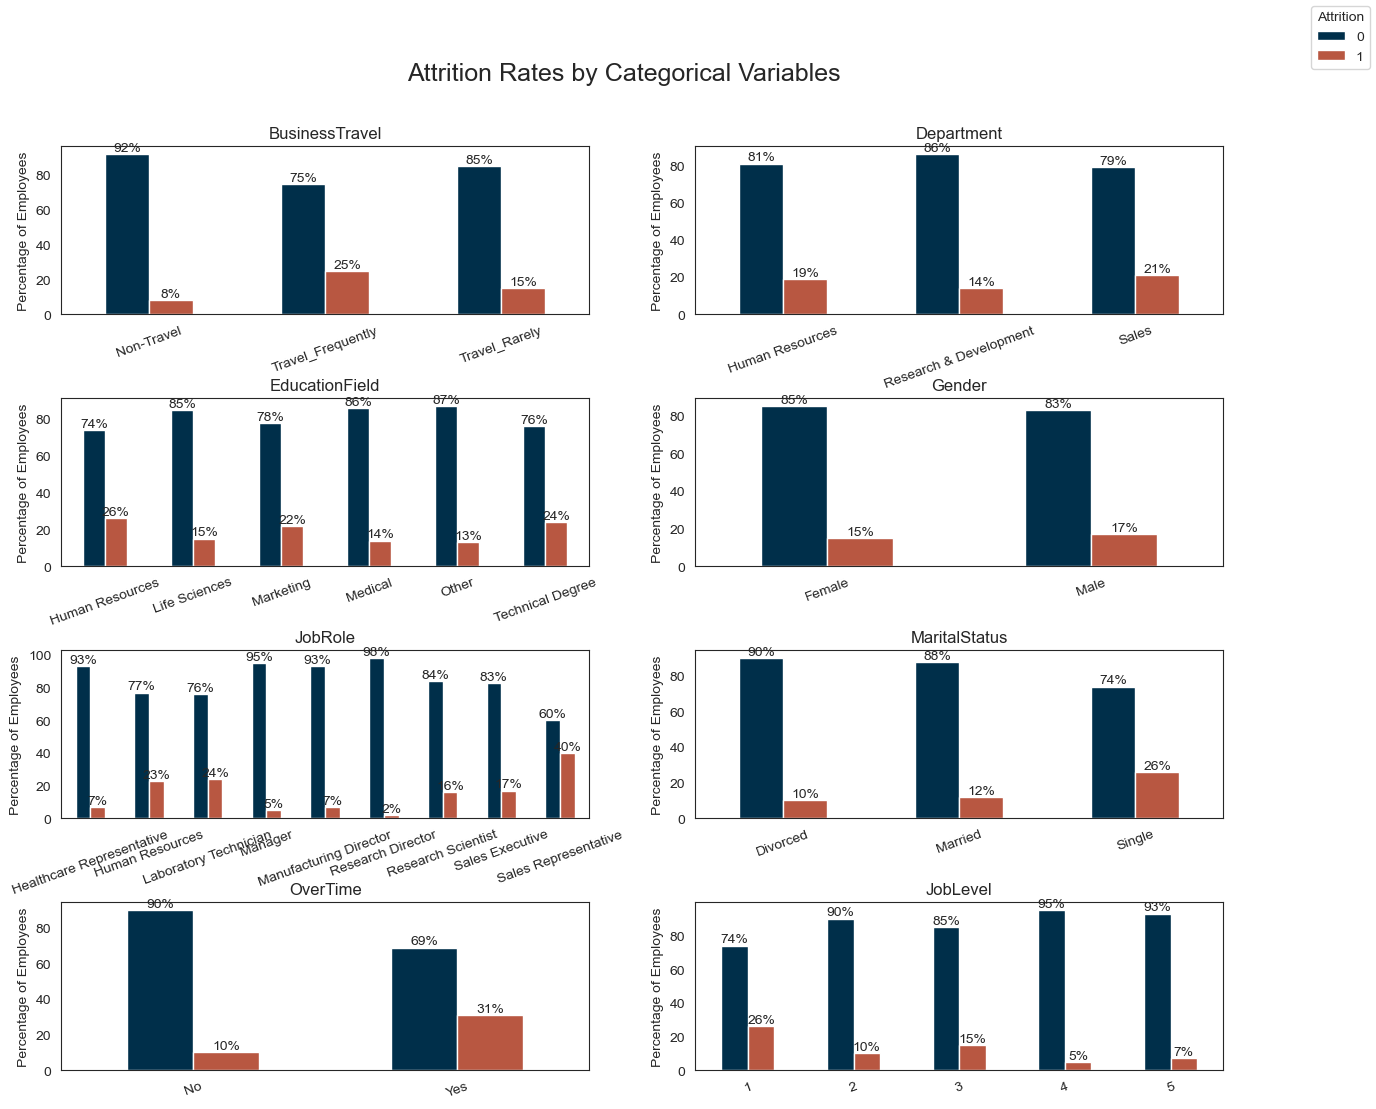

In [49]:
target_cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime', 'JobLevel']

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Attrition Rates by Categorical Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(target_cat_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'Attrition']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='Attrition', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Attrition')

plt.show();

Observations:
* R&D make up the majority of employees, but they have lower attrition than HR and Sales. This trend is further illustrated when viewing attrition by Job Role and Education Field.
    * Overtime and frequent travel do not vary significantly between departments.
* Attrition is similar for males and females.
* Attrition is heightened for employees working overtime, traveling frequently, for single employees, and entry level employees. 

### Distribution of Attrition by Engagement-Related Metrics

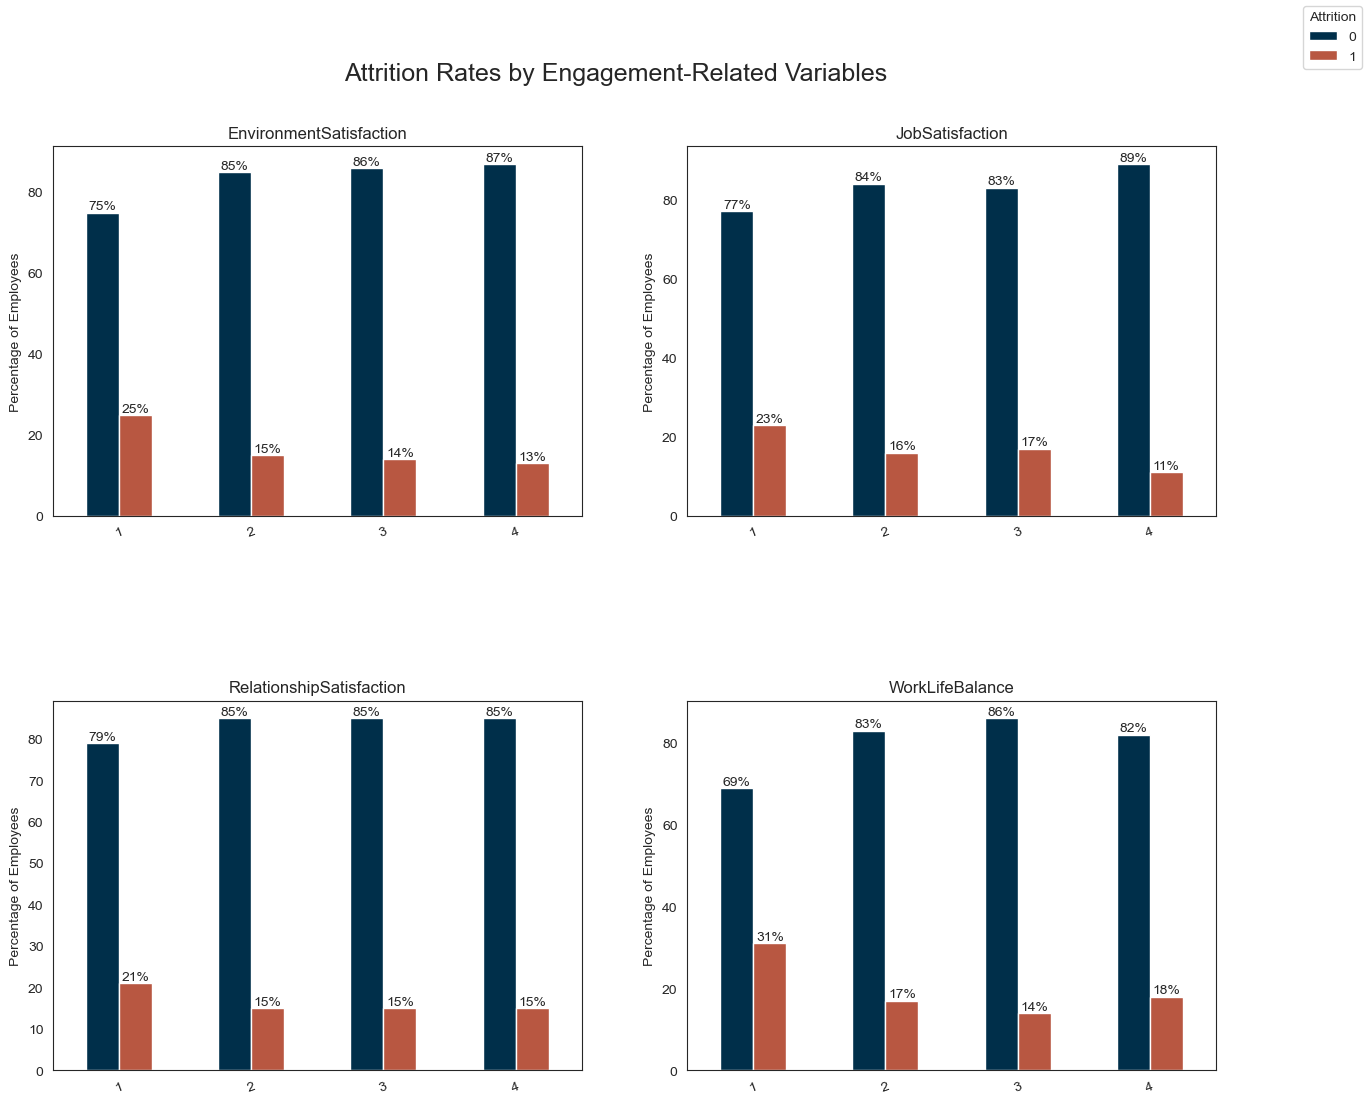

In [50]:
eng_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance']

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Attrition Rates by Engagement-Related Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(eng_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'Attrition']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='Attrition', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Attrition')

plt.show();

* Higher attrition rates with satisfaction decreases, further illustrated by table below.

### Engagement Metrics x Job Role

In [51]:
deptEng = hr_clean.groupby(['Department', 'Attrition'])[['JobSatisfaction','WorkLifeBalance','EnvironmentSatisfaction','RelationshipSatisfaction']].mean().reset_index()
deptEng

,Department,Attrition,JobSatisfaction,WorkLifeBalance,EnvironmentSatisfaction,RelationshipSatisfaction
0,Human Resources,0,2.705882,2.921569,2.764706,2.843137
1,Human Resources,1,2.166667,2.916667,2.333333,3.083333
2,Research & Development,0,2.769324,2.748792,2.787440,2.739130
3,Research & Development,1,2.458647,2.578947,2.473684,2.518797
4,Sales,0,2.810734,2.836158,2.734463,2.706215
5,Sales,1,2.521739,2.739130,2.467391,2.652174


In [52]:
hr_clean.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

### Distrubtion of Attrition by Numeric Columns

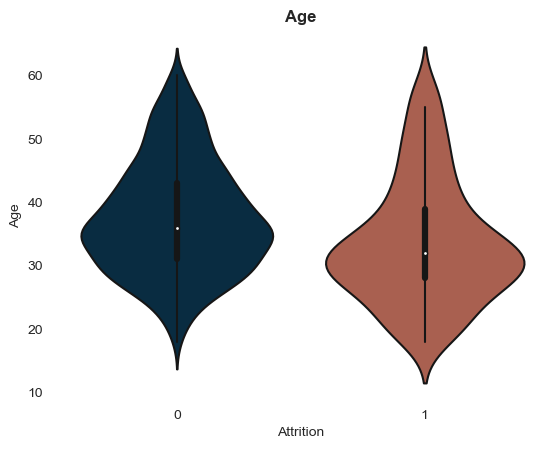

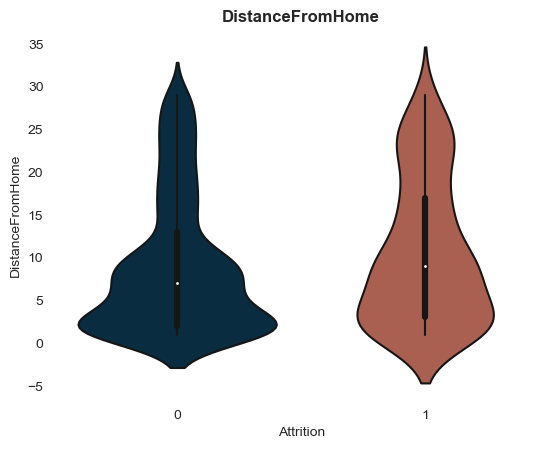

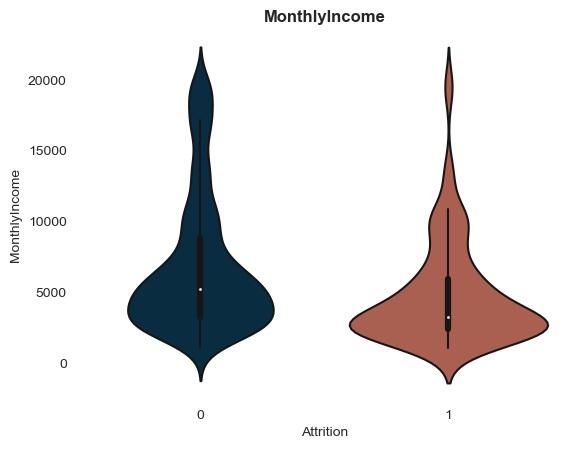

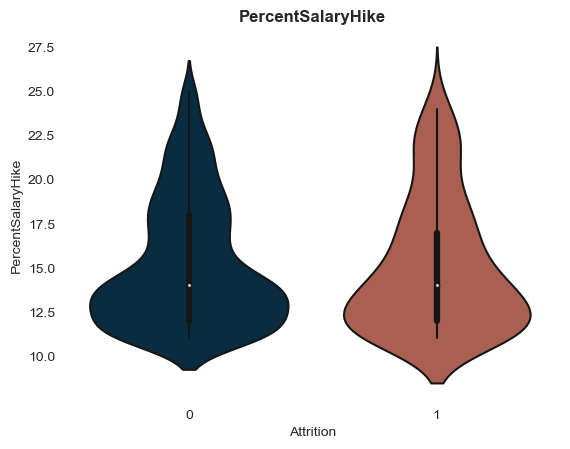

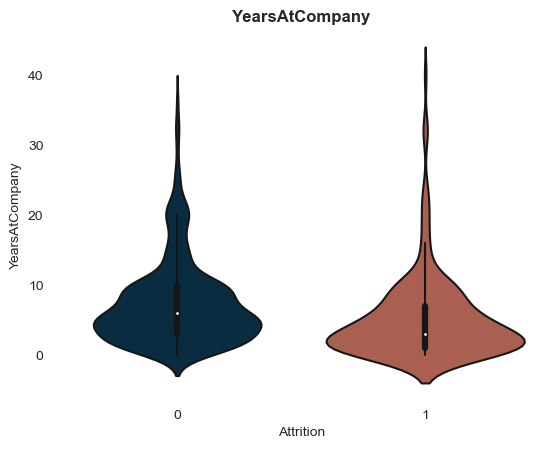

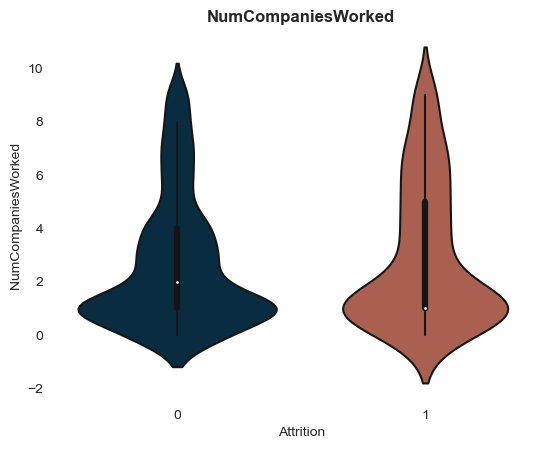

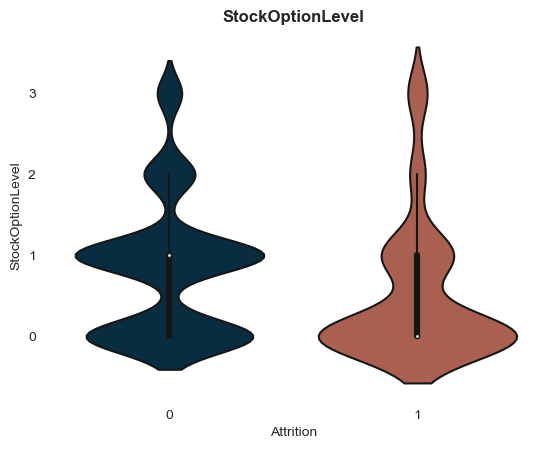

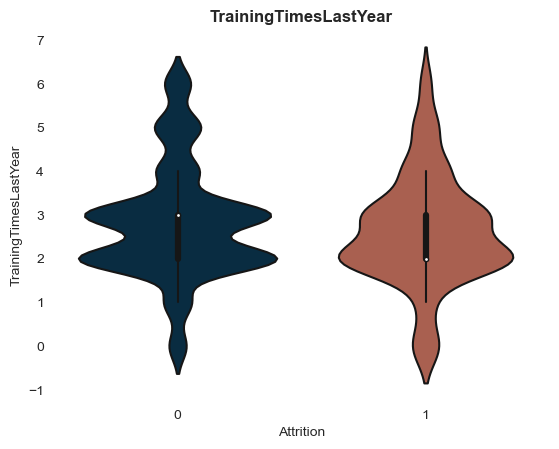

In [53]:
target_num_cols = ['Age', 'DistanceFromHome','MonthlyIncome','PercentSalaryHike', 'YearsAtCompany', 
'NumCompaniesWorked','StockOptionLevel','TrainingTimesLastYear']

def make_violin(df, x_var, y_var):
    sns.set_palette(["#002f4a", "#b85741"])
    ax = sns.violinplot(data= df, x = x_var, y = y_var, split= True)
    plt.title(y_var, weight= 'bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.show();

for col in target_num_cols:
    make_violin(hr_clean, 'Attrition', col)

* Not a lot of apparent trends; leavers appear to generally have a lower stock option level.

### Correlation Matrix


In [54]:
#Create dummy variables
hr_dummies = hr_clean.copy()
hr_dummies['Gender'] = hr_dummies['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
hr_dummies['OverTime'] = hr_dummies['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)
hr_dummies['BusinessTravel'] = hr_dummies['BusinessTravel'].apply(lambda x: 0 if x == 'Non-Travel' else
                                                                  1 if x == 'Travel_Rarely' else 3 )

#Grab dummies for cat vars of interest - mostly just dropping perf rating bc it has virtually no variance
hr_dummies = pd.get_dummies(hr_dummies, columns=['Department', 'MaritalStatus', 'JobRole', 'EducationField'], drop_first=True)

hr_dummies.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,MaritalStatus_Married,MaritalStatus_Single,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree
0,41,1,1,1102,1,2,2,0,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,49,0,3,279,8,1,3,1,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,37,1,1,1373,2,2,4,1,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,33,0,3,1392,3,4,4,0,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,27,0,1,591,2,1,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


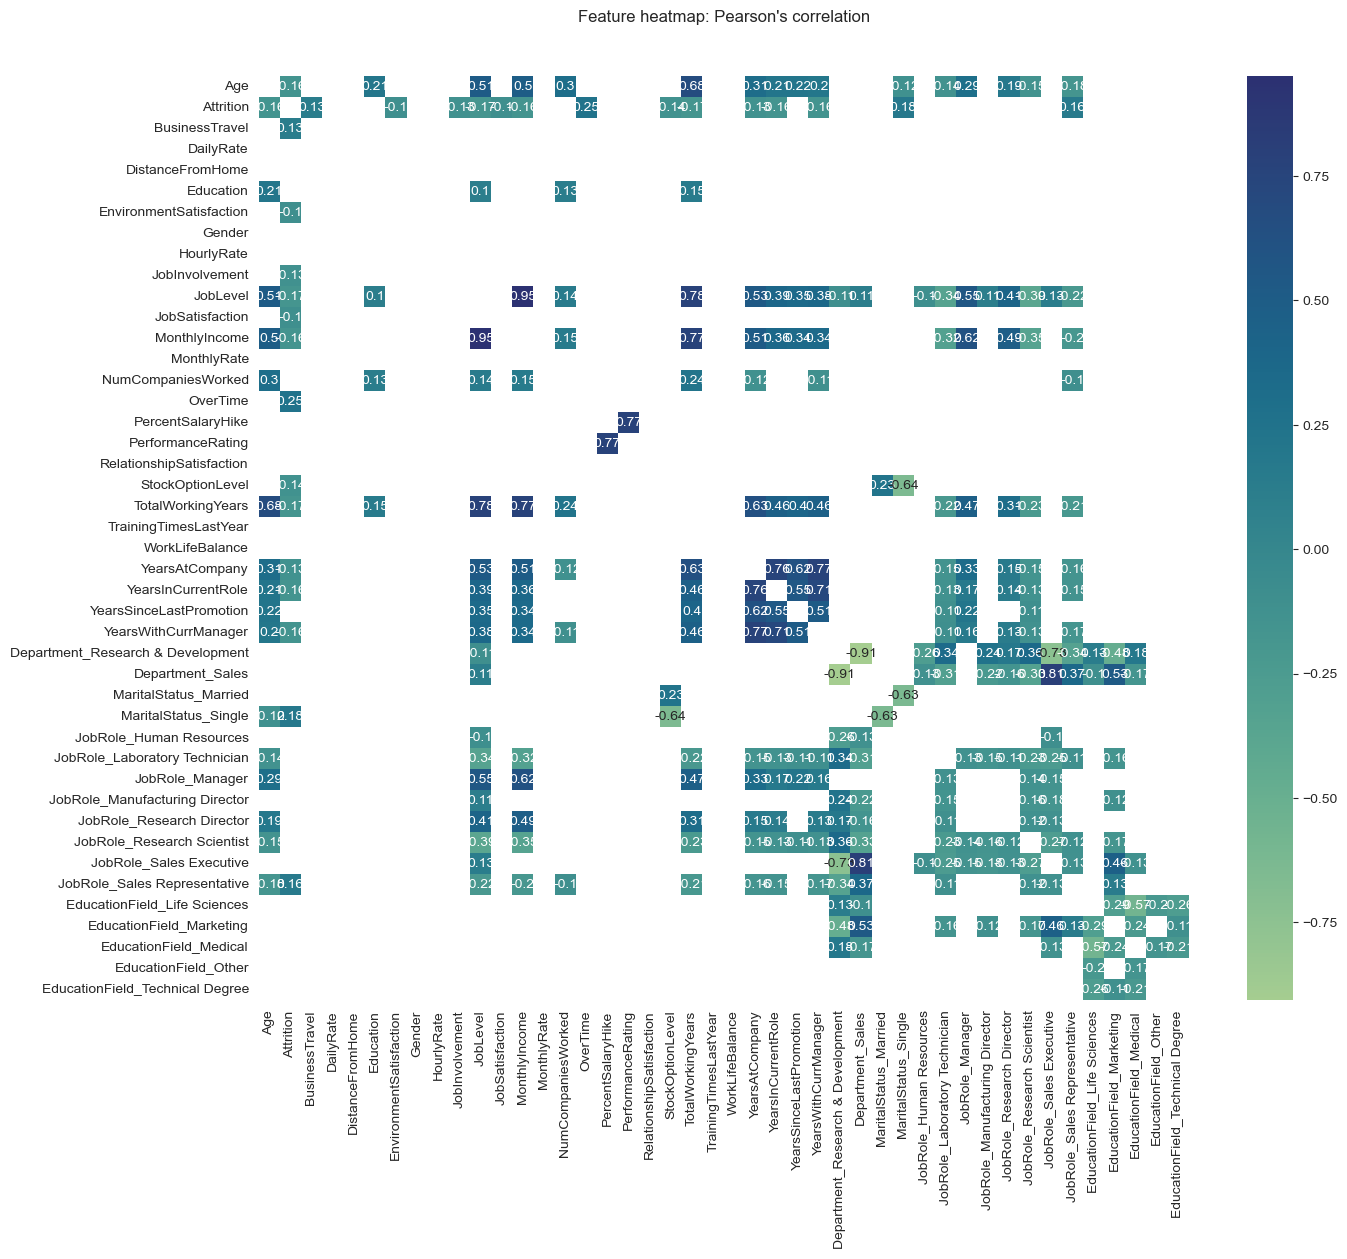

In [55]:
#create pearson correlation heatmap of features
corrs = hr_dummies.corr()

#only show corrs between .2 and 1 for readability (corr = 1 is just self correlation)
plt.figure(figsize=(15,12))
sns.heatmap(corrs[((corrs>0.1)&(corrs<1)) | (corrs < -.1)], cmap='crest', annot=True)
plt.title("Feature heatmap: Pearson's correlation", y = 1.05);

Let's get a better view of what correlates with attrition.

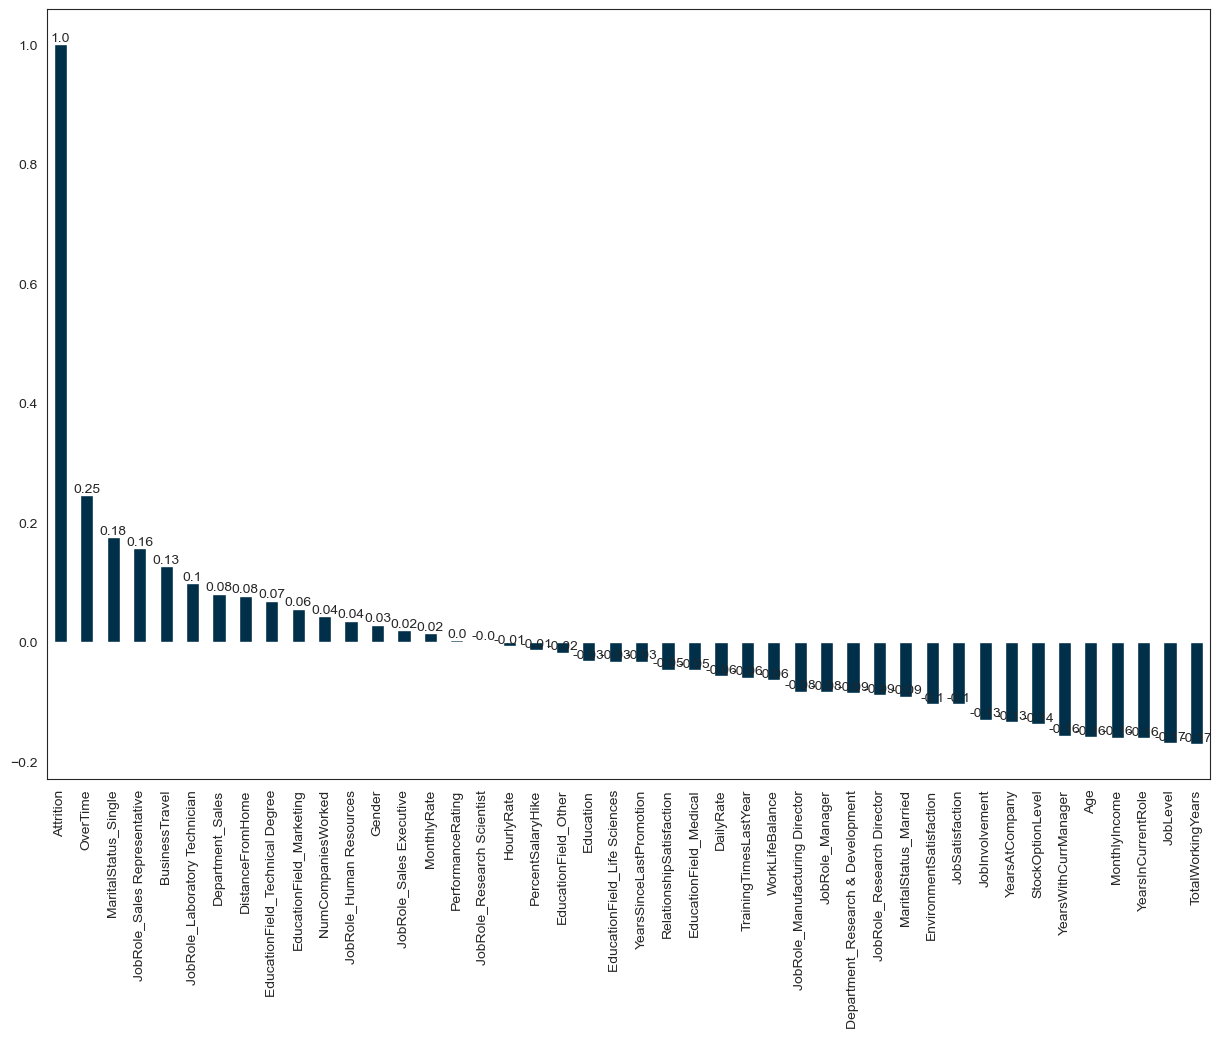

In [56]:
plt.figure(figsize=(15,10))
corplot = corrs['Attrition'].sort_values(ascending = False).plot(kind='bar')
# Add labels to the bars
for i, val in enumerate(corrs['Attrition'].sort_values(ascending=False)):
    corplot.text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontsize': 10})
plt.show();



## Feature Selection
Currently, our model could have up to ~50 features. I'll aim to reduce this number to limit model complexity. Here are my guiding principles using the data preview, EDA, and domain knowledge:
1. Include job engagement related features - This are can be insightful, actionable, and research suggests these may drive attrition. Keep:
* RelationshipSatisfaction
* EnvironmentSatisfaction
* WorkLifeBalance
* JobSatisfaction

2a. Remove features w/ < .05 correlation with attrition. <br> 
2b. Eliminate features that are highly inter-correlated. Inter-correlated features will not add enough incremental uniqueness or value to the model. Through EDA and reviewing inter-correlations, I'll select features I think will be most insightful and strike through the eliminated features.
* OverTime
* MaritalStatusSingle
* BusinessTravel
* JobRoleLabTech
* ~~DepartmentSales~~
* DistanceFromHome
* EducationFieldTechnical.Degree
* EducationFieldMarketing
* ~~TotalWorkingYears~~
* JobLevel
* ~~YearsInCurrentRole~~
* MonthlyIncome
* Age
* ~~YearsWithCurrManager~~
* StockOptionLevel
* YearsAtCompany
* MaritalStatusMarried
* JobRoleResearch.Director
* MaritalStatusDivorced
* ~~DeparmentResearchAndDev~~
* JobRoleManager
* JobRoleManufacturingDirector
* JobRoleHealthcare.Rep
* TrainingTimesLastYear

Final List:
* RelationshipSatisfaction
* EnvironmentSatisfaction
* WorkLifeBalance
* JobSatisfaction
* OverTime
* MaritalStatusSingle
* BusinessTravel
* JobRoleLabTech
* DistanceFromHome
* EducationFieldTechnical.Degree
* EducationFieldMarketing
* JobLevel
* MonthlyIncome
* Age
* StockOptionLevel
* YearsAtCompany
* MaritalStatusMarried
* JobRoleResearch.Director
* JobRoleManager
* JobRoleManufacturingDirector
* TrainingTimesLastYear




In [57]:
hr_final = hr_dummies[['Attrition', 
                       'RelationshipSatisfaction',
                       'EnvironmentSatisfaction',
                       'WorkLifeBalance',
                       'JobSatisfaction',
                       'OverTime',
                       'MaritalStatus_Single',
                       'BusinessTravel',
                       'JobRole_Laboratory Technician',
                       'DistanceFromHome',
                       'EducationField_Technical Degree',
                       'EducationField_Marketing',
                       'JobLevel',
                       'MonthlyIncome',
                       'Age',
                       'StockOptionLevel',
                       'YearsAtCompany',
                       'MaritalStatus_Married',
                       'JobRole_Research Director',
                       'JobRole_Manager',
                       'JobRole_Manufacturing Director',
                       'TrainingTimesLastYear']]

In [58]:
hr_final.head()

,Attrition,RelationshipSatisfaction,EnvironmentSatisfaction,WorkLifeBalance,JobSatisfaction,OverTime,MaritalStatus_Single,BusinessTravel,JobRole_Laboratory Technician,DistanceFromHome,EducationField_Technical Degree,EducationField_Marketing,JobLevel,MonthlyIncome,Age,StockOptionLevel,YearsAtCompany,MaritalStatus_Married,JobRole_Research Director,JobRole_Manager,JobRole_Manufacturing Director,TrainingTimesLastYear
0,1,1,2,1,4,1,1,1,0,1,0,0,2,5993,41,0,6,0,0,0,0,0
1,0,4,3,3,2,0,0,3,0,8,0,0,2,5130,49,1,10,1,0,0,0,3
2,1,2,4,3,3,1,1,1,1,2,0,0,1,2090,37,0,0,0,0,0,0,3
3,0,3,4,3,3,1,0,3,0,3,0,0,1,2909,33,0,8,1,0,0,0,3
4,0,4,1,3,2,0,0,1,1,2,0,0,1,3468,27,1,2,1,0,0,0,3


## Data Modeling

Let's start with a regression model.
Due to class imbalance, I'll do the following:
* Logistic regression with an L1 penalty (Lasso - help reduce complexity and optimize performance)
* K-folds cross-validation to evaluate performance/reliable against different subsets (folds) of the data
* 80/20 split to fit the model and make test predictions. Review strongest features as sources of attrition drivers.

##### K-Folds Cross Validation

In [59]:
# Define cross validation function
def kfold_cv(model, X, y, splits = 10, repeats = 3):
    # Set up repeated kfolds for cross validation
    # By default, data will be split into ten folds that will each be used as training and testing sets to evaluate reliability
    # (and this is repeated 3 times), making us more confident in the generalizability of the model
    cv = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=42)

    # set up scorer
    # selecting some standard evaluation measures to give an overview of model performance
    scoring = {
        'accuracy': make_scorer(accuracy_score), # What % of predictions was the model correct on?
        'sensitivity': make_scorer(recall_score), # aka recall or true positive rate; What % correctly identified as turnover?
                                                # true positive / all actual positive
        'specificity': make_scorer(recall_score,pos_label=0), # aka true negative rate; What % correctly identified as stayer?
                                                            # true negative / all actual negative
        'precision': make_scorer(precision_score), # aka positive predictive value; of all predicted as leavers, what % were correct?
                                                # true positive / all pred. positive
        'AUC': make_scorer(roc_auc_score), # area under ROC curve; ROC plots illustrates trade off between true pos rate and false pos rate
                                            # higher value under this curve represents lower trade off/better performing model
                }
    
    #Cross validate and report performance
    scores = cross_validate(model, X, y, scoring= scoring, cv=cv, n_jobs=-1)

    #report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
    print('Sensitivity: %.3f (%.3f)' % (np.mean(scores['test_sensitivity']), np.std(scores['test_sensitivity'])))
    print('Specificity: %.3f (%.3f)' % (np.mean(scores['test_specificity']), np.std(scores['test_specificity'])))
    print('Precision: %.3f (%.3f)' % (np.mean(scores['test_precision']), np.std(scores['test_precision'])))
    print('AUC: %.3f (%.3f)' % (np.mean(scores['test_AUC']), np.std(scores['test_AUC'])))

In [60]:
# set up training and testing sets
X = hr_final.drop('Attrition', axis = 1)
y = hr_final['Attrition']

#80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size =.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# confirm imbalnance
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

# create Logistic Regression model
att_model = LogisticRegression(solver = 'liblinear', # useful for datasets < 10k
                                   penalty='l1') # lasso penalty that optimizes for model simplicity while optimizing performance

# cross validate
kfold_cv(att_model, X_train, y_train)



(1176, 21)
(294, 21)
(1176,)
(294,)


0    0.831633
1    0.168367
Name: Attrition, dtype: float64

0    0.867347
1    0.132653
Name: Attrition, dtype: float64

Accuracy: 0.869 (0.025)
Sensitivity: 0.338 (0.111)
Specificity: 0.976 (0.014)
Precision: 0.730 (0.196)
AUC: 0.657 (0.055)


* Our accuracy is quite high, so our model is correct most of the time; however, this comes at the expense of sensitivity. Our model is conservative with classifying employees as leavers. This is unsurprising given the imbalanced nature of the data. Given this validation, I expect to see similar results upon prediction below.

##### Make Predictions on Test Set and Evaluate

In [61]:
#fit on training data
att_model.fit(X_train, y_train)
#predict
att_log_pred = att_model.predict(X_test)



LogisticRegression(penalty='l1', solver='liblinear')

In [77]:
#Define function for evaluating our model
def eval_model(predictions, actual):
    #Evaluate model
    #print confusion matrix
    cf = pd.DataFrame(confusion_matrix(y_true = actual, y_pred = predictions))

    # calculate scores from confusion matrix values
    t_neg, f_pos, f_neg, t_pos = confusion_matrix(y_true = actual, y_pred = predictions).ravel()

    #accuracy
    acc = accuracy_score(y_true = actual, y_pred = predictions)
    print(acc)
    #sensitivity
    sens = recall_score(y_true = actual, y_pred = predictions)
    #specifiction
    spec = t_neg / (t_neg+f_pos)
    #precision
    prec = precision_score(y_true = actual, y_pred = predictions)
    #ROC AUC
    auc = roc_auc_score(y_true = actual, y_score = predictions)

    #report performance
    print('Confusion Matrix:')
    print(cf)
    print('Accuracy: %.3f' % (acc))
    print('Sensitivity: %.3f' % (sens))
    print('Specificty: %.3f' % (spec))
    print('Precision: %.3f' % (spec))
    print('AUC: %.3f' % (auc))
    

In [63]:
#Evaluate model
eval_model(att_log_pred, y_test)

0.8843537414965986
Confusion Matrix:
     0   1
0  248   7
1   27  12
Accuracy: 0.884
Sensitivity: 0.308
Specificty: 0.973
Precision: 0.973
AUC: 0.640


* As expected, the model performed similarly with our test data.
* Before moving on, let's look into feature performance to see what it driving attrition.

In [64]:
# Function to return features and log odds (exponentiated coefficients)
# This tell us for each feature, if holding all other constant, how does its presence increase/decrease
# the liklihood of turnover; above 1 OR means odds of turnover are increases; opposite for below 1
def get_or(model, X):
    print(f"Model Intercept (Exponentiated): {np.exp(model.intercept_)}")

    features = pd.DataFrame(X.columns)
    odds_r = pd.DataFrame(np.exp(model.coef_))
    odds_r = odds_r.melt(var_name ='num', value_name='odds ratio')

    log_odds = pd.concat([features, odds_r], axis =1)
    log_odds.drop('num', axis = 1, inplace=True)
    log_odds = log_odds.sort_values(by = 'odds ratio', ascending = False)
    print(log_odds)
    

In [65]:
#Get feature importance
get_or(att_model, X_train)

Model Intercept (Exponentiated): [1.19980239]
                                  0  odds ratio
4                          OverTime    5.924475
5              MaritalStatus_Single    3.070309
9   EducationField_Technical Degree    2.269545
7     JobRole_Laboratory Technician    1.832153
10         EducationField_Marketing    1.776518
6                    BusinessTravel    1.573030
16            MaritalStatus_Married    1.241687
8                  DistanceFromHome    1.030763
18                  JobRole_Manager    1.000000
12                    MonthlyIncome    0.999985
13                              Age    0.978061
15                   YearsAtCompany    0.966596
0          RelationshipSatisfaction    0.937013
20            TrainingTimesLastYear    0.894944
11                         JobLevel    0.858174
14                 StockOptionLevel    0.849517
2                   WorkLifeBalance    0.821582
1           EnvironmentSatisfaction    0.739824
3                   JobSatisfaction    0.7

This model gives us some insight on what might be driving attrition, however, its low sensitivity makes it less practical for usage for identifying actual exits. To try to improve sensitivity, next steps could include the following.
1. Manually lower our threshold for predicting attrition to below .5. This would cause our model to classify someone as an exit more often. However, this would inflate our false positive rate. This has pros and cons depending upon how this model is leveraged in the business.
2. Using a resampling technique to balance the data 
3. Try out an ensemble technique (AdaBoost, Bagging, etc.) or other techniques that better handle imbalance (XGBoost)

For the purposes of this case study, I'll choose one path to explore: resampling. I'm choosing resampling because I would like to stick with the interpretability of logistic regression modeling in this context.

#### Resampling Approach: SMOTE
SMOTE selects random neighbors of random minority class members and then creates a new observation of the minority class based on the features between the neighbor and the random class member; this is done repeatedly until imbalance is resolved. I will not be applying smote to the test set, as I want this to accurately represent actual org data.

In [66]:
#Use SMOTE to oversample our minority class (attrition) to address class imbalance
X_train_sm, y_train_sm = SMOTE(sampling_strategy=1, random_state = 42).fit_resample(X_train, y_train)
print(X_train_sm.shape)
print(y_train_sm.shape)
y_train_sm.value_counts(normalize=True)

# smote model
sm_model = LogisticRegression(solver = 'liblinear', # useful for datasets < 10k
                                   penalty='l1') # lasso penalty that optimizes for model simplicity while optimizing performance

# cross validate
kfold_cv(sm_model, X_train_sm, y_train_sm)


(1956, 21)
(1956,)


0    0.5
1    0.5
Name: Attrition, dtype: float64

Accuracy: 0.816 (0.027)
Sensitivity: 0.815 (0.040)
Specificity: 0.818 (0.043)
Precision: 0.817 (0.045)
AUC: 0.816 (0.028)


* This model performs quite well during cross validation. Accuracy has decreased a bit but sensitivity has improved immensely. However, a better indication of success will be with the test data that has not been resampled, since that it more representative of the true class imbalance at the company.

* As expected, our model didn't perform as well with the imbalanced test data. However, sensitivity performance is still improved from the original model. 

In [69]:
#Get feature importance
get_or(sm_model, X_train)

Model Intercept (Exponentiated): [2029.59686551]
                                  0  odds ratio
4                          OverTime    2.854394
6                    BusinessTravel    1.257555
8                  DistanceFromHome    1.022941
12                    MonthlyIncome    1.000154
15                   YearsAtCompany    0.975156
13                              Age    0.973561
20            TrainingTimesLastYear    0.770860
0          RelationshipSatisfaction    0.742821
9   EducationField_Technical Degree    0.682281
3                   JobSatisfaction    0.603049
1           EnvironmentSatisfaction    0.594647
10         EducationField_Marketing    0.572836
2                   WorkLifeBalance    0.570710
7     JobRole_Laboratory Technician    0.529786
11                         JobLevel    0.528811
14                 StockOptionLevel    0.383061
5              MaritalStatus_Single    0.347266
16            MaritalStatus_Married    0.269723
19   JobRole_Manufacturing Director    

Our AUC shows that our SMOTE model performs slightly better than our imbalanced model. While accuracy and specificity have taken a hit, our sensitivity has improved a bit, though it is hardly better than chance. While most of our feature importance themes remain the same, some have shifted in a puzzling way. For example, Single employees are now predicted to be more likely to stay after SMOTE. My conclusions for these models are as follow:
1. The first model is optimal for interpreting what our attrition drivers are and will be used for presentation purposes.
2. The second model indicates that additional engineering can be done to achieve better predictive qualities, though interpretability may decrease.
* Next Steps: More advanced feature selection techniques such as incorporating ANOVA and chi-square may be helpful in more precisely reducing the number of features in the model. In doing so, this should help both model performance and interpretability.

#### Model 3: Will an ensemble approach (XGboost) improve sensitivity?

Findings below indicate the XGboost model is not performing better than our logistic regression modeling.

In [97]:

#split training data into a training set a validation set
X_train_xg, X_valid_xg, y_train_xg, y_valid_xg = train_test_split(X_train, y_train, random_state=42, test_size =.2)

#use y train to get estimate of best value for scale_pos_weight
#this is a weight that is applied to positive classifications that scales the gradient 
#scaling the gradient encourages the model to over-correct for errors when classifying the positive outcome (turnover)
y_train_xg.value_counts()

#scale_pos_weight = num stayers/num leavers
estimate = 978/198
estimate

xgModel = XGBClassifier(scale_pos_weight=estimate,
                        n_estimators=500
                        )

xgModel.fit(X_train_xg, y_train_xg,
            # allows the model to stop before the 500 iterations if validation stops improving
            early_stopping_rounds=5,
            #provide validation set to allow for early stopping
              eval_set=[(X_valid_xg, y_valid_xg)],
              verbose=False)

kfold_cv(xgModel, X_train_xg, y_train_xg)

# predict on original, unseen test set
xg_pred = xgModel.predict(X_test)

#Evaluate model on original, unseen test set
eval_model(xg_pred, y_test)




0    787
1    153
Name: Attrition, dtype: int64

4.9393939393939394

c:\Users\maris\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Accuracy: 0.843 (0.038)
Sensitivity: 0.398 (0.126)
Specificity: 0.930 (0.028)
Precision: 0.521 (0.174)
AUC: 0.664 (0.068)
0.8367346938775511
Confusion Matrix:
     0   1
0  235  20
1   28  11
Accuracy: 0.837
Sensitivity: 0.282
Specificty: 0.922
Precision: 0.922
AUC: 0.602


#### Closer Look: Over Time

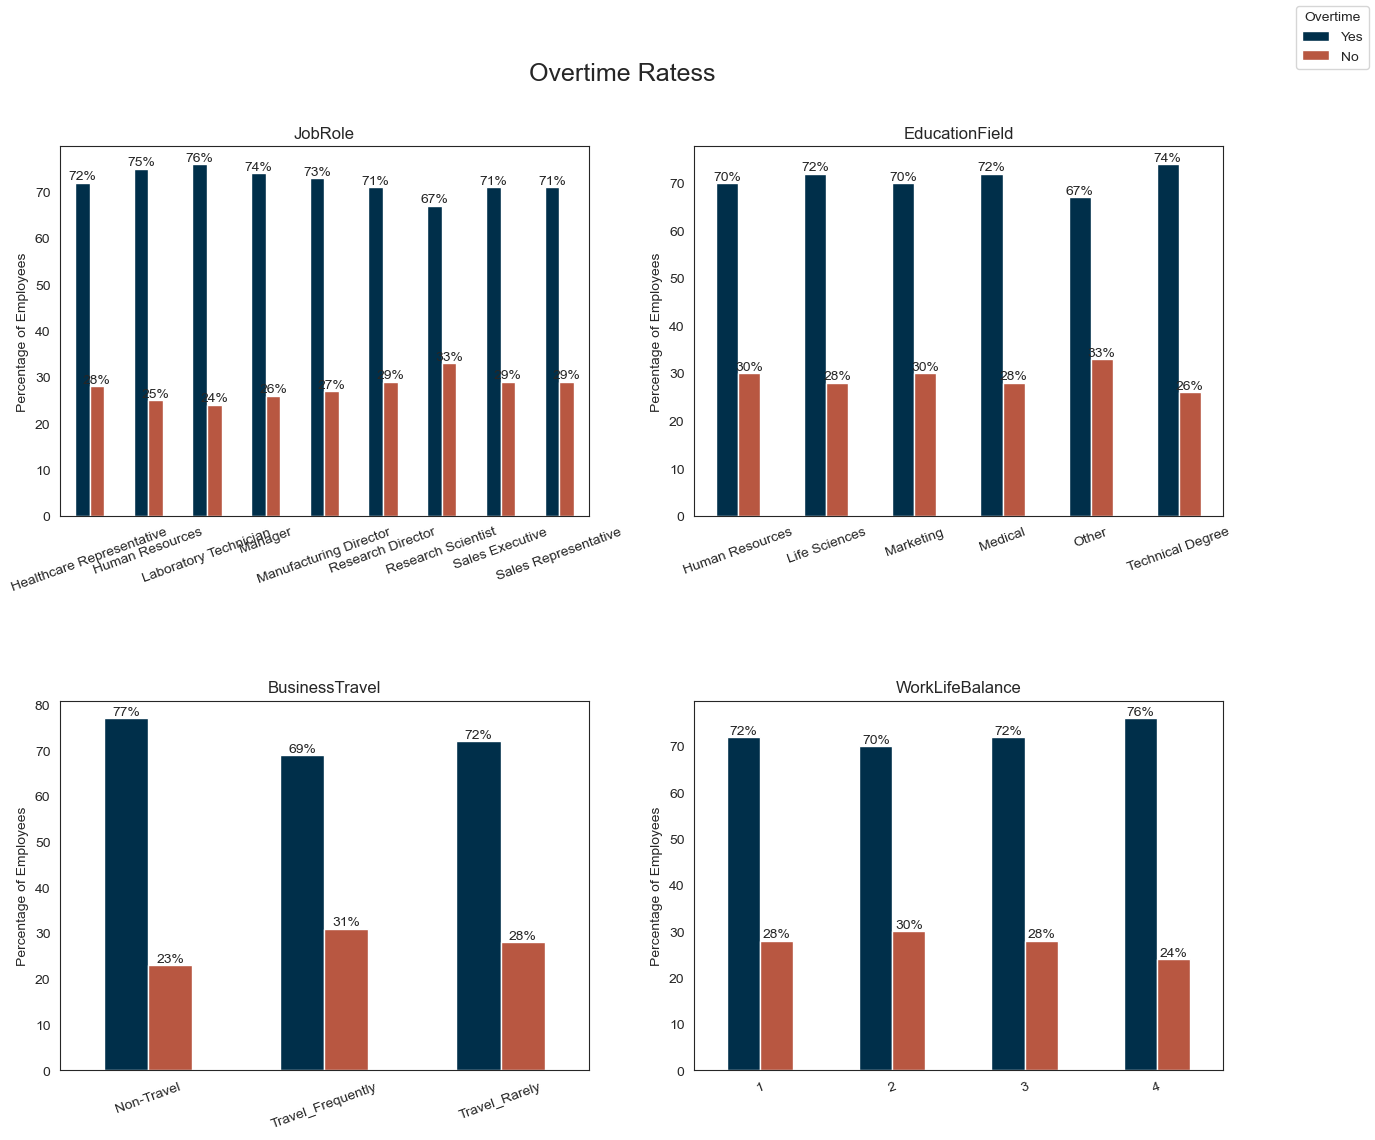

In [70]:
ot_cols = ['JobRole', 'EducationField', 'BusinessTravel', 'WorkLifeBalance']

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Overtime Ratess", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(ot_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'OverTime']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='OverTime', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Overtime')

plt.show();

In [71]:
otEng = hr_clean.groupby(['Attrition'])[['JobSatisfaction','WorkLifeBalance','EnvironmentSatisfaction','RelationshipSatisfaction']].mean().reset_index()
otEng

,Attrition,JobSatisfaction,WorkLifeBalance,EnvironmentSatisfaction,RelationshipSatisfaction
0,0,2.778589,2.781022,2.771290,2.733982
1,1,2.468354,2.658228,2.464135,2.599156


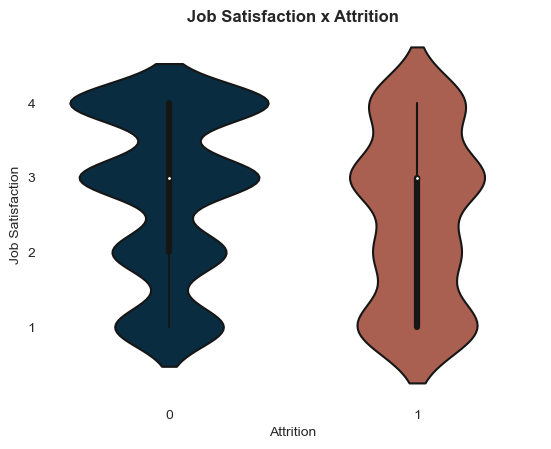

In [72]:
#JobSat x Attrition
sns.set_palette(["#002f4a", "#b85741"])
ax = sns.violinplot(data= hr_clean, x = "Attrition", y = "JobSatisfaction")
plt.title('Job Satisfaction x Attrition', weight= 'bold')
ax.set_ylabel('Job Satisfaction')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show();




#### What's driving Job Satisfaction?
Given the lack of employee experience/engagement data in the data set, we're a bit limited in how we can determine job satisfaction drivers. Since Job Satisfaction is on an ordinal scale from 1-4, we'll run an ordinal logistic regression to see if we can identify some drivers.

Overall, we aren't seeing significant results, which is unsurprising given the scale of the data we have (range restriction, unclear validity of the measure, lack of measurement of other drivers of job satisfaction). Given Job Satisfaction is a driver of attrition, and we have other drivers of attrition related to other employee demographics (notably job role), I think we have a case to partner with the employee listening team and see how their holistic engagement measure may reveal patterns amongst these employee demographics.

In [73]:
hr_clean.groupby(['JobRole'])[['JobSatisfaction','WorkLifeBalance','EnvironmentSatisfaction','RelationshipSatisfaction']].mean().reset_index()


,JobRole,JobSatisfaction,WorkLifeBalance,EnvironmentSatisfaction,RelationshipSatisfaction
0,Healthcare Representative,2.786260,2.702290,2.770992,2.694656
1,Human Resources,2.557692,2.923077,2.596154,2.961538
2,Laboratory Technician,2.691120,2.718147,2.718147,2.687259
3,Manager,2.705882,2.774510,2.764706,2.813725
4,Manufacturing Director,2.682759,2.765517,2.917241,2.724138
5,Research Director,2.700000,2.862500,2.500000,2.687500
6,Research Scientist,2.773973,2.678082,2.726027,2.705479
7,Sales Executive,2.754601,2.803681,2.671779,2.702454
8,Sales Representative,2.734940,2.891566,2.734940,2.602410


In [74]:

y = hr_dummies['JobSatisfaction']
X = hr_dummies[['RelationshipSatisfaction', 'JobInvolvement', 'WorkLifeBalance', 'BusinessTravel', 'JobRole_Research Director',
                    'JobRole_Manager', 'JobRole_Laboratory Technician', 'MonthlyIncome', 'OverTime']]
# Add constant
X = sm.add_constant(X)

ol_model = sm.OLS(y, X)
ol_logit = ol_model.fit()

# Print the summary of the model
print(ol_logit.summary())


                            OLS Regression Results                            
Dep. Variable:        JobSatisfaction   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3703
Date:                Mon, 29 May 2023   Prob (F-statistic):              0.949
Time:                        11:09:03   Log-Likelihood:                -2227.6
No. Observations:                1470   AIC:                             4475.
Df Residuals:                    1460   BIC:                             4528.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

## Key Takeaways and Next Steps
* Reviewing policies surrounding overtime and business travel can help mitigate negative impact on attrition while maintaining benefits of these practices.
* With policy optimized, additional hiring strategies can be applied to increase org. resilience to turnover.
* Deeper insights on the impact of Job Satisfaction on turnover, esp. with respect to vulnerable job roles, can be further investigated using holistic employee engagement measures.


**Modeling:**
Strengths:
* Intuitive and actionable drivers of promotion
* SMOTE model shows promise in improving sensitivity when testing on imbalance data

Areas for Further Development:
* Model complexity and feature reduction
    * The shifting of some of the feature importances (odds ratios) suggest to me some noise that still exists with respect to all of the features chosen. This noise level makes me cautious to take a literal interpretation of the odds ratios rather than using them for general directionality and magnitude ranking.
    * More advanced techniques can be used to more holistically model the relationship between the features (such as ANOVA and chi-square) to help further reduce the number of features to the most unique and predictive features.

* Improving sensitivity
    * Like the attrition model, we still don’t have very high sensitivity, which is most helpful for identifying those who will turnover. With our current model, we can manually alter the threshold for classifying an employee as turning over (reducing to to below 50%) if we are comfortable with the impacts on accuracy and AUC. Or we can further iterate on our model. Improve feature selection should help with this, but like the attrition analysis, we can also:
        * Experiment with additional ensemble approaches
            * Research key parameters
            * Employ grid search for hyperparameter tuning

